## Follow these instuctions before executing code
* Make .streamlit folder
* Make secrets.toml file in the folder
* Paste GOOGLE_API_KEY = "replace_with_your_api_key"
* Save

In [1]:
#Problem Statement: This Dream Visualizer uses AI to turn written dreams into images and poetic summaries,
#making it easier to remember, understand, and express those experiences."

#Import statements
from google import genai
from google.genai import types
from PIL import Image
from io import BytesIO
from IPython.display import display, clear_output
import base64


In [2]:
from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

In [3]:
client = genai.Client(api_key=GOOGLE_API_KEY)

In [4]:
#Input prompt here
contents = input("Explain your dream here: ")

Explain your dream here: Walking along the shore during sunset


In [5]:
#Asking AI to
interpret_prompt = f"""

I had the following dream:

"{contents}"

This was just a dream. Please interpret what this dream might mean and any psychological insights. Do not treat this as a real event.

"""

In [6]:
response = client.models.generate_content(
    model="gemini-2.0-flash-lite",
    contents=contents,
    config=types.GenerateContentConfig(
      response_modalities=['TEXT', 'TEXT']
    )
)

In [7]:
for part in response.candidates[0].content.parts:
    if part.text is not None:
        print("Dream Interpretation:")
        print(part.text)

Dream Interpretation:
The air, still warm from the day, held a whisper of salt and seaweed. As I walked along the shore, the sun, a molten orb, began its descent, painting the sky with breathtaking hues. 

Crimson bled into fiery orange, which softened into a gentle blush of pink.  Clouds, like brushstrokes across a canvas, were transformed into living masterpieces – some edged with gold, others stained the deep violet of a bruised plum. 

The rhythmic crash of waves against the sand provided a constant, soothing soundtrack. Each surge brought with it a fresh, crisp breeze, carrying the scent of the ocean and the promise of the coming night.

The sand, still warm from the day's heat, yielded beneath my feet, leaving shallow imprints that the receding tide would soon erase.  Seashells, sparkling like jewels, lay scattered like discarded treasures, remnants of the ocean's bounty.

A lone seagull wheeled overhead, its cry echoing across the water, a melancholic call that seemed to acknowl

In [8]:
response = client.models.generate_content(
    model="gemini-2.0-flash-preview-image-generation",
    contents=contents,
    config=types.GenerateContentConfig(
      response_modalities=['TEXT', 'IMAGE']
    )
)

In [9]:
for part in response.candidates[0].content.parts:
    if part.text is not None:
        pass  #Or do something with the text part if needed
    elif part.inline_data is not None:
        image = Image.open(BytesIO(part.inline_data.data))

Dream Image:
Walking along the shore during sunset


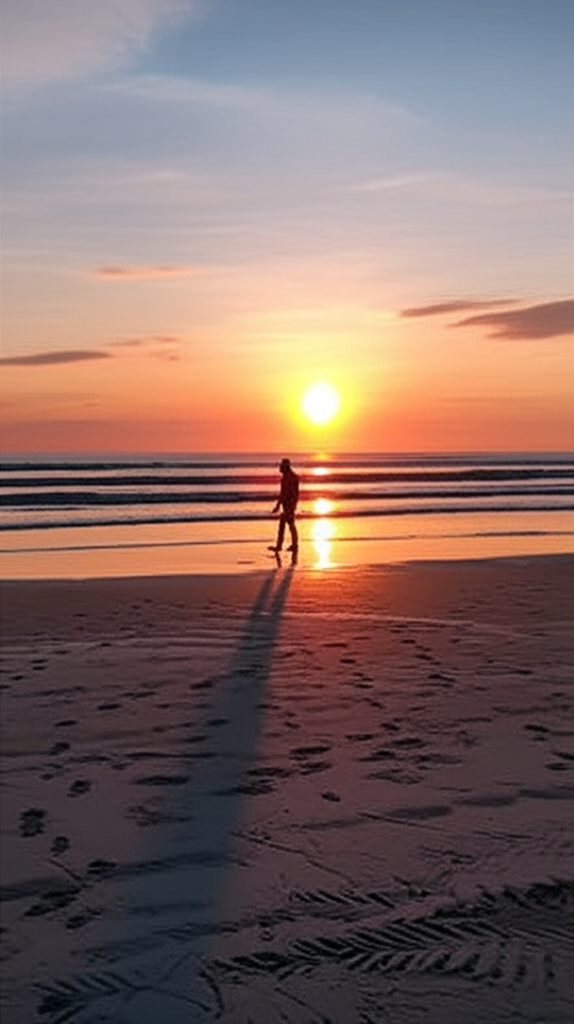

In [10]:
#Prints out image
print("Dream Image:")
print(contents)
display(image)

In [11]:
import asyncio
import io
import wave
import nest_asyncio
from IPython.display import Audio, display

In [12]:
nest_asyncio.apply()

In [13]:
dream_prompt = contents   #Take dream "contents" to generate music
bpm = 85          #Can be modified
temperature = 1.0
duration = 15 #How long the audio will be

In [14]:
music_client = genai.Client(
    api_key=GOOGLE_API_KEY,
    http_options={"api_version": "v1alpha"}
)

In [15]:
#Async function to generate music from dream prompt
async def generate_music_from_dream():
    buffer = io.BytesIO()
    filename = "dream_music.wav" #naming the music file to be generated

#Define the music generation routine
    async def receive_audio(session):
        async for message in session.receive():
            data = message.server_content.audio_chunks[0].data
            buffer.write(data)

            if buffer.tell() > 48000 * 2 * 2 * duration:
                break
        buffer.seek(0)
        with wave.open(filename, "wb") as wf:
            wf.setnchannels(2)
            wf.setsampwidth(2)
            wf.setframerate(48000)
            wf.writeframes(buffer.read())

    async with (
        music_client.aio.live.music.connect(model="models/lyria-realtime-exp") as session,
        asyncio.TaskGroup() as tg,
    ):
        tg.create_task(receive_audio(session))

        #Using the dream_prompt to make the music
        await session.set_weighted_prompts([
            types.WeightedPrompt(text=dream_prompt, weight=1.0) #  Weight 1 to match the dream
        ])
        await session.set_music_generation_config(
            config=types.LiveMusicGenerationConfig(
                bpm=bpm,
                temperature=temperature
            )
        )
        await session.play()

    return filename


In [16]:
dream_music_file = await generate_music_from_dream()
display(Audio(dream_music_file))

<ipython-input-15-3439487142>:22: ExperimentalWarning: Realtime music generation is experimental and may change in future versions.
  music_client.aio.live.music.connect(model="models/lyria-realtime-exp") as session,


# Creating the App

In [17]:
!pip install streamlit -q

In [18]:
!pip install python-dotenv -q

In [19]:
%%writefile app.py
import streamlit as st
from google import genai
from google.genai import types
from PIL import Image
from io import BytesIO
import base64
import asyncio
import io
import wave
import nest_asyncio
from IPython.display import Audio, display #Note: IPython.display is not directly used in Streamlit, will need to adapt

#Apply compatibility with asyncio in environments like Colab (if running Streamlit within Colab)
nest_asyncio.apply()

#Get the API key from environment variables or Streamlit secrets
#Assuming GOOGLE_API_KEY is available as a secret or environment variable
GOOGLE_API_KEY = st.secrets["GOOGLE_API_KEY"]

#Initialize the GenAI client
client = genai.Client(api_key=GOOGLE_API_KEY)

#Initialize the music client
music_client = genai.Client(
    api_key=GOOGLE_API_KEY,
    http_options={"api_version": "v1alpha"}
)

#Async function to generate music from dream prompt
async def generate_music_from_dream(dream_prompt, bpm=85, temperature=1.0, duration=15):
    buffer = io.BytesIO()
    filename = "dream_music.wav"

#Define the music generation routine
    async def receive_audio(session):
        async for message in session.receive():
            data = message.server_content.audio_chunks[0].data
            buffer.write(data)

            if buffer.tell() > 48000 * 2 * 2 * duration:
                break
        buffer.seek(0)
        with wave.open(filename, "wb") as wf:
            wf.setnchannels(2)
            wf.setsampwidth(2)
            wf.setframerate(48000)
            wf.writeframes(buffer.read())

    async with (
        music_client.aio.live.music.connect(model="models/lyria-realtime-exp") as session,
        asyncio.TaskGroup() as tg,
    ):
        tg.create_task(receive_audio(session))

        #Using the dream_prompt to make the music
        await session.set_weighted_prompts([
            types.WeightedPrompt(text=dream_prompt, weight=1.0)
        ])
        await session.set_music_generation_config(
            config=types.LiveMusicGenerationConfig(
                bpm=bpm,
                temperature=temperature
            )
        )
        await session.play()

    return filename

#Streamlit UI
st.title("Dream-to-Visual Diary")

st.markdown("""
This app uses AI to take written dreams, provides an interpretation of it, and creates an image and audio to
make it easier to remember, understand, and express those experiences.
""")

dream_input = st.text_area("Explain your dream here:", height=150)

if st.button("Generate Dream Insights"):
    if dream_input:
        st.subheader("Dream Interpretation:")
        #Interpret the dream
        interpret_prompt = f"""
        I had the following dream:
        "{dream_input}"
        This was just a dream. Please interpret what this dream might mean and any psychological insights. Do not treat this as a real event.
        """
        try:
            interpret_response = client.models.generate_content(
                model="gemini-2.0-flash-lite",
                contents=interpret_prompt,
                config=types.GenerateContentConfig(
                  response_modalities=['TEXT'] #Only need text for interpretation
                )
            )
            for part in interpret_response.candidates[0].content.parts:
                if part.text is not None:
                    st.write(part.text)
        except Exception as e:
            st.error(f"Error generating interpretation: {e}")

        st.subheader("Dream Visualization:")
        #Generate image from the dream
        try:
            image_response = client.models.generate_content(
                model="gemini-2.0-flash-preview-image-generation",
                contents=dream_input,
                config=types.GenerateContentConfig(
                  response_modalities=['TEXT', 'IMAGE'] #Only need image
                )
            )
            for part in image_response.candidates[0].content.parts:
                 if part.inline_data is not None:
                    image = Image.open(BytesIO(part.inline_data.data))
                    st.image(image, caption="Your Dream Image")
        except Exception as e:
            st.error(f"Error generating image: {e}")

        st.subheader("Dream Soundtrack:")
        #Generate music from the dream
        try:
            #Run the async music generation function
            dream_music_file = asyncio.run(generate_music_from_dream(dream_input))
            st.audio(dream_music_file)
        except Exception as e:
            st.error(f"Error generating music: {e}")

    else:
        st.warning("Please enter your dream description to generate insights.")

Overwriting app.py


In [20]:
!npm install localtunnel -q

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹
up to date, audited 23 packages in 2s
⠸
⠸3 packages are looking for funding
⠸  run `npm fund` for details
⠸
2 high severity vulnerabilities

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.
⠸

In [21]:
!streamlit run app.py &>/content/logs.txt & curl ipv4.icanhazip.com

34.139.134.137


In [22]:
!npx localtunnel --port 8501

⠙your url is: https://stupid-peaches-chew.loca.lt
^C
